# Interpretability tutorial

In this tutorial we will go through several popular visualization techniques that help interpret deep learning networks.

We will cover:
1. Filter visualization
2. Feature/ activation visualization with PyTorch hooks
3. CNN Layer Visualization
4. Gradient visualization with Guided backpropagation
5. Gradient Class Activation Maps (grad-CAM)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np 
import visualizations
from visualizations.src.misc_functions import *
from visualizations.src.guided_backprop import GuidedBackprop
from visualizations.src.cnn_layer_visualization import CNNLayerVisualization
from visualizations.src.gradcam import GradCam
from visualizations.src.deep_dream import DeepDream

device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")



## Exercise 1. Weights Visualization

https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e

https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb#scrollTo=uQI9jHcP6xfP

One of the first things you can visualize in your network - is your network weights.
Your convolutional kernels have weights which are updated during training, and can be visualized by calling the weight data inside your network.

Let's first load and print a pretrained network using pytorch.models:

In [2]:
# first load pretrained alxenet model
alexnet = models.alexnet(pretrained=True)
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/cb19/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:13<00:00, 18518656.06it/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

We can see that the network is made up of two sequential models - features, and classifier.

To visualize the convolutional weights, we need to access a convolutional layer in the features model.

This can be done in the following way:
```python 
weight_tensor = model.features[layer_num].weight.data
```
**Note that layer_num should correspond to a convolutional layer - otherwise there are no weights to be visualized.**

We will now define a few functions to help with plotting:

In [3]:
def plot_filters_single_channel(t):
    
    kernels_to_plot = 30
    channels_to_plot = 3
    #total kernels depth * number of kernels
    nplots = channels_to_plot*kernels_to_plot
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(kernels_to_plot):
        for j in range(channels_to_plot):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()    

    
def plot_filters_multi_channel(t):
    
    kernels_to_plot = 60
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = kernels_to_plot // num_cols
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(kernels_to_plot):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()
    plt.show()
    


We next define our plot weights function, which first extracts the weights of a convolutional filter, and then passes into an appropriate image plotting function.

### Task 1.1 - edit the `plot_weights` function to return the weights tensor corresponding to layer `layer_num`

In [4]:
def plot_weights(model, layer_num, single_channel = True):
    #extracting the model features at the particular layer number
    layer = model.features[layer_num]
  
    #checking whether the layer is convolution layer or not 

    if isinstance(layer, nn.Conv2d):
        #getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data
        print('weight_tensor.shape',weight_tensor.shape)
        if single_channel:
            plot_filters_single_channel(weight_tensor)
        
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
        
    else:
        print("Can only visualize layers which are convolutional")


### Task 1.2 Explain 

- what do the weights of your network represent? 
- what is the difference between a kernel and a filter (**hint** see lecture 4)
- Layer 3 (the second convolution) has a weights matrix of size `[192, 64, 5, 5]`. What does each dimension represent? How many filters does it learn, how many kernels?

#### Answer here:

### Task 1.3  Visualise weights for different layers.

- plot the weights for different colvolutional layers
- Note the purpose of parameter `single_channel=False` is to plot all filters as a single image. **However** this is only possible for 3 channel output - where it can be plotted in RGB; 
- try plotting the output of the first layer with `single_channel=True`, then `single_channel=False` to see the difference
- What do the numbers above the plots mean? How many outputs are being returned and why (**hint** check the plotting functions)? How do you determine how many 
- try editing the plotting functions to include input arguments which vary the numbers of kernels plot per filter for each layer

weight_tensor.shape torch.Size([384, 192, 3, 3])


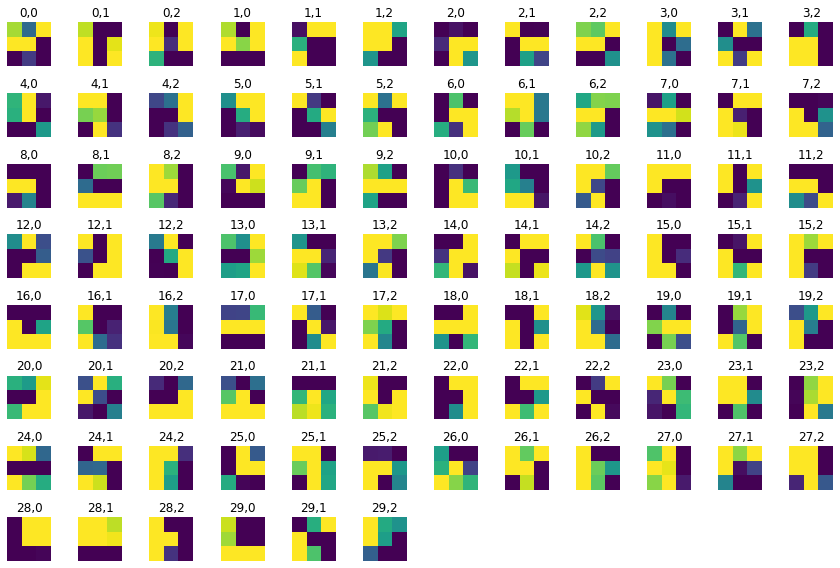

In [6]:
#visualize weights for alexnet - first conv layer
plot_weights(alexnet, 6, single_channel = True)

## Exercise 2. Activation visualization with PyTorch Hooks

Another effective approach to examine what your network is learning, is the visualize your network's features or activations, i.e. intermediate outputs of your network for a specific inputs. 

Let's use MNIST for this example. Loading train and validation DataLoaders, and generating a similar basic convolutional network to which we used in Lecture 2:

In [7]:
mnist_train_dataset = datasets.MNIST(root = 'mnist_data/train', download= True, train = True, transform = transforms.ToTensor())
mnist_test_dataset = datasets.MNIST(root = 'mnist_data/test', download= True, train = False, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
       mnist_train_dataset, batch_size= 8, shuffle = True)

test_loader = torch.utils.data.DataLoader(
       mnist_test_dataset, batch_size = 8, shuffle = True)

classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:03, 2820988.55it/s]                             


Extracting mnist_data/train/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 125174.14it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/train/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:02, 563953.09it/s]                             
0it [00:00, ?it/s]

Extracting mnist_data/train/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 48995.96it/s]            
0it [00:00, ?it/s]

Extracting mnist_data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


9920512it [00:09, 1016771.95it/s]                             


Extracting mnist_data/test/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 127714.75it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/test/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 925320.87it/s]                             
0it [00:00, ?it/s]

Extracting mnist_data/test/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 48120.52it/s]            


Extracting mnist_data/test/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [8]:
class MNIST_Model(nn.Module):
    def __init__(self):
        super(MNIST_Model, self).__init__()
    
        self.conv1=nn.Conv2d(1, 10, 3)
        self.maxpool1=nn.MaxPool2d(2)
        self.dropout1=nn.Dropout2d()
        
        self.conv2=nn.Conv2d(10, 20, 3)
        self.maxpool2=nn.MaxPool2d(2)
        self.dropout2=nn.Dropout2d()
        
        self.lin_blocks = nn.Sequential(
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            #nn.Softmax(),
        )
        
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = x.view(x.size(0),-1)
        #print(x.shape)
        x = self.lin_blocks(x)

        return F.log_softmax(x,dim=1)

    
net = MNIST_Model() 
print(net)
net = net.to(device)

loss_fun = nn.CrossEntropyLoss()
loss_fun = loss_fun.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


MNIST_Model(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.5)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.5)
  (lin_blocks): Sequential(
    (0): Linear(in_features=500, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [9]:
epochs = 1
for epoch in range(epochs): 

    # enumerate can be used to output iteration index i, as well as the data 
    for i, (data, labels) in enumerate(train_loader, 0):
        
        # Task 3.1 load data and labels to device
        data = data.to(device)
        labels = labels.to(device)
        
        # --------------------------------------------------task 2 ------------------------------------------------------------
        # 3.2: implement training iteration here
        # clear the gradient
        optimizer.zero_grad()

        #3.3 feed the input and acquire the output from network
        outputs = net(data)

        #3.4 calculating the predicted and the expected loss
        loss = loss_fun(outputs, labels)

        #3.5 compute the gradient
        loss.backward()

        #3.6 update the parameters
        optimizer.step()
        # ---------------------------------------------------------------------------------------------------------------------

        # print statistics
        ce_loss = loss.item()
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))


[1,     1] loss: 2.425
[1,    11] loss: 2.287
[1,    21] loss: 2.337
[1,    31] loss: 2.295
[1,    41] loss: 2.322
[1,    51] loss: 2.301
[1,    61] loss: 2.383
[1,    71] loss: 2.327
[1,    81] loss: 2.297
[1,    91] loss: 2.372
[1,   101] loss: 2.258
[1,   111] loss: 2.321
[1,   121] loss: 2.296
[1,   131] loss: 2.312
[1,   141] loss: 2.324
[1,   151] loss: 2.275
[1,   161] loss: 2.375
[1,   171] loss: 2.297
[1,   181] loss: 2.342
[1,   191] loss: 2.302
[1,   201] loss: 2.255
[1,   211] loss: 2.283
[1,   221] loss: 2.282
[1,   231] loss: 2.318
[1,   241] loss: 2.266
[1,   251] loss: 2.241
[1,   261] loss: 2.240
[1,   271] loss: 2.251
[1,   281] loss: 2.284
[1,   291] loss: 2.278
[1,   301] loss: 2.182
[1,   311] loss: 2.208
[1,   321] loss: 2.263
[1,   331] loss: 2.257
[1,   341] loss: 2.219
[1,   351] loss: 2.125
[1,   361] loss: 2.271
[1,   371] loss: 2.150
[1,   381] loss: 2.310
[1,   391] loss: 2.342
[1,   401] loss: 2.221
[1,   411] loss: 2.272
[1,   421] loss: 2.226
[1,   431] 

[1,  3581] loss: 0.276
[1,  3591] loss: 1.085
[1,  3601] loss: 0.174
[1,  3611] loss: 0.272
[1,  3621] loss: 0.210
[1,  3631] loss: 1.074
[1,  3641] loss: 0.177
[1,  3651] loss: 0.404
[1,  3661] loss: 0.048
[1,  3671] loss: 0.665
[1,  3681] loss: 0.840
[1,  3691] loss: 0.641
[1,  3701] loss: 0.686
[1,  3711] loss: 0.055
[1,  3721] loss: 0.932
[1,  3731] loss: 0.170
[1,  3741] loss: 0.190
[1,  3751] loss: 0.092
[1,  3761] loss: 0.809
[1,  3771] loss: 0.255
[1,  3781] loss: 1.071
[1,  3791] loss: 0.041
[1,  3801] loss: 0.502
[1,  3811] loss: 0.122
[1,  3821] loss: 1.041
[1,  3831] loss: 0.486
[1,  3841] loss: 0.093
[1,  3851] loss: 0.106
[1,  3861] loss: 0.572
[1,  3871] loss: 1.887
[1,  3881] loss: 0.108
[1,  3891] loss: 0.219
[1,  3901] loss: 0.827
[1,  3911] loss: 0.474
[1,  3921] loss: 0.166
[1,  3931] loss: 0.099
[1,  3941] loss: 0.837
[1,  3951] loss: 0.398
[1,  3961] loss: 1.180
[1,  3971] loss: 0.351
[1,  3981] loss: 0.081
[1,  3991] loss: 0.416
[1,  4001] loss: 0.274
[1,  4011] 

[1,  7161] loss: 0.878
[1,  7171] loss: 0.678
[1,  7181] loss: 0.114
[1,  7191] loss: 0.073
[1,  7201] loss: 0.266
[1,  7211] loss: 0.085
[1,  7221] loss: 0.365
[1,  7231] loss: 0.539
[1,  7241] loss: 0.743
[1,  7251] loss: 0.146
[1,  7261] loss: 0.171
[1,  7271] loss: 0.015
[1,  7281] loss: 0.026
[1,  7291] loss: 0.087
[1,  7301] loss: 0.096
[1,  7311] loss: 0.110
[1,  7321] loss: 0.005
[1,  7331] loss: 0.862
[1,  7341] loss: 0.423
[1,  7351] loss: 0.255
[1,  7361] loss: 0.762
[1,  7371] loss: 0.117
[1,  7381] loss: 0.214
[1,  7391] loss: 0.152
[1,  7401] loss: 0.278
[1,  7411] loss: 1.064
[1,  7421] loss: 0.307
[1,  7431] loss: 0.244
[1,  7441] loss: 0.060
[1,  7451] loss: 0.615
[1,  7461] loss: 0.213
[1,  7471] loss: 0.201
[1,  7481] loss: 0.635
[1,  7491] loss: 0.002


### Understanding PyTorch Hooks

Hooks are functions with which you can modify or return different sub-components of your network. Returning the outputs of different layers (i.e. the activations - the goal of this section) is thus an excellent example. In general the point is that they are simply functions that are run whenever the `forward` or `backward` function of a `torch.Autograd.Function` object is called i.e. the `grad_fn` of a tensor (discussed in Lecture 2). 

You can register a function on a `Module` or a `Tensor` and are defined apriori as forward hooks or a backward hooks. Depending on which they are they will either be executed when a forward call is executed (forward hook) or a backward pass in run (backward hook). 

Let's look at using a forward and backward hook just for debugging (and thus printing) the output of a function (example taken from [the official PyTorch tutorials](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html))

A forward hook has the general form:

```python
model.conv_name.register_forward_hook(hook_function(module, input,output))
```

And a backward hook has a general form

```python
model.conv_name.register_backward_hook(hook_function(module,grad_input,grad_output))
```

Say we are interested in layer $l$. A forward hook function can look at inputs and outputs the layer during the forward pass i.e. the input activation from layer $l-1$ and the output activation for layer $l$. The backward pass can look at the inputs and outputs to the backward pass i.e. the incoming (input) gradient with respect to the parameters from the layer above $l+1$ and the outgoing (output) gradient with respect to the parameters of the current layer $l$.

Thus if we wish to print information about the input and output activations we can use:

In [10]:
def printnorm(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('Inside ' + self.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('output norm:', output.data.norm())


print_forward_handle=net.conv1.register_forward_hook(printnorm)

#--------------------- ---- ----------------------------#
# performing forward pass
out = net(data)

Inside Conv2d forward

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([8, 1, 28, 28])
output size: torch.Size([8, 10, 26, 26])
output norm: tensor(145.6300, device='cuda:0')


And to return backward pass outputs and inputs use:

In [11]:
def printgradnorm(self, grad_input, grad_output):
    print('Inside ' + self.__class__.__name__ + ' backward')
    print('Inside class:' + self.__class__.__name__)
    print('')
    print('grad_input: ', type(grad_input))
    print('grad_input[0]: ', type(grad_input[0]))
    print('grad_output: ', type(grad_output))
    print('grad_output[0]: ', type(grad_output[0]))
    print('')
    print('grad_input size:', grad_input[0].size())
    print('grad_output size:', grad_output[0].size())
    print('grad_input norm:', grad_input[0].norm())


print_backward_handle=net.conv2.register_backward_hook(printgradnorm)

out = net(data)
err = loss_fun(out,labels)
err.backward()

Inside Conv2d forward

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([8, 1, 28, 28])
output size: torch.Size([8, 10, 26, 26])
output norm: tensor(145.6300, device='cuda:0')
Inside Conv2d backward
Inside class:Conv2d

grad_input:  <class 'tuple'>
grad_input[0]:  <class 'torch.Tensor'>
grad_output:  <class 'tuple'>
grad_output[0]:  <class 'torch.Tensor'>

grad_input size: torch.Size([8, 10, 13, 13])
grad_output size: torch.Size([8, 20, 11, 11])
grad_input norm: tensor(0.1650, device='cuda:0')


By naming your hooks e.g.

```
print_forward_handle=model.conv1.register_forward_hook(printnorm)

```
it is possible to remove them as:

In [12]:
print_forward_handle.remove()
print_backward_handle.remove()

More information on hooks can be found in https://www.kaggle.com/sironghuang/understanding-pytorch-hooks and https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/ should you be interested.

### Task 2.1. Register hook to get network activations for a given input

Thus hooks are functions that can be applied to the inputs and outputs of our forwards and backwards layers and as such we can use them to return the activations of each layer.

**To do ** Modify the below code to use the hook function `get_activation` to save the activation tensor for the first convolutional layer of your network:

We define the function for you. All you need to do is:

1. Create a (forward or backward) hook 
2. Pass it the hook function `get_activation`. Here, the argument `name` is expecting the name of the layer. Yhe name is what you call the variable in your `__init__` function i.e. `conv1,pool1... ` etc in this instance

10 10


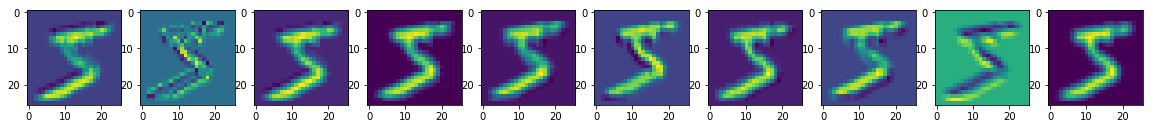

In [18]:

# Set up the hook for activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

#--------------------- Task 2.1 ----------------------------#
# Create a hook on the first convolutional layer
#
net.conv1.register_forward_hook(get_activation('conv1'))

#--------------------- ---- ----------------------------#
data, _ = mnist_train_dataset[0]
data = data.to(device)
data.unsqueeze_(0)

# Run through model again, to save the relavent activation
output = net(data)

# Visualize the activation
act = activation['conv1'].squeeze()

print(act.size(0),min(act.size(0),10))
fig, axarr = plt.subplots(1,min(act.size(0),10),figsize=(20,20))
n_plots=min(act.size(0),10)
for idx in np.arange(n_plots):
    axarr[idx].imshow(act.cpu()[idx])


### Task 2.2: Visualise an activation of another convolutional layer

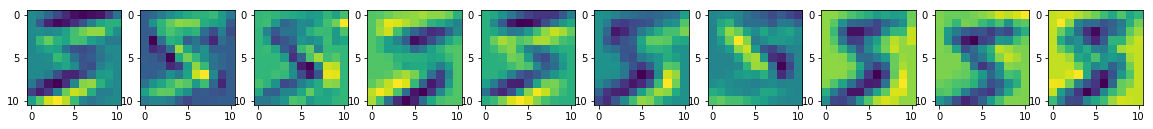

In [20]:
# --------------------------------------------- Task 2 --------------------------------------------------------
# write code here

# Register the hook with the convolutional layer of interest
net.conv2.register_forward_hook(get_activation('conv2'))

# Run through model again, to save the relavent activation
output = net(data)

# Visualize the activation
act = activation['conv2'].squeeze()
fig, axarr = plt.subplots(1,min(act.size(0),10),figsize=(20,20))
n_plots=min(act.size(0),10)
for idx in np.arange(n_plots):
    axarr[idx].imshow(act.cpu()[idx])


### Task 2.3 Explain 

1. How can you interpret the activations of different layers? What does that mean with respect to the relative importance of different parts of your image?

# Feature Visualisation and Attribution

When it comes to techniques for visualising and interpretting what an individual network is learning there are two main sub-fields: feature visualisation and feature attribution:

### Feature visualisation

This represents the category of methods which attempt to understand through backwards designing inputs, which maximize the activation of individual units (neurons/channels/layers) of networks, whereas

### Feature attribution (saliency mapping) 
Reflect methods which seek to backpropagate maps which highlight which parts of an image are important for activation of a specific unit

We start by discussing saliency mapping though occlusion as this can be meaningfully tested with MNIST.

# Attribution (saliency mapping)

### Exercise 3: Saliency by occlusion

In a related sense we will now try to interpret what our network is doing by occluding different parts/proportions of our image to see what impact this has on classification. Let's return a batch of images from our validation DataLoader and visualise them

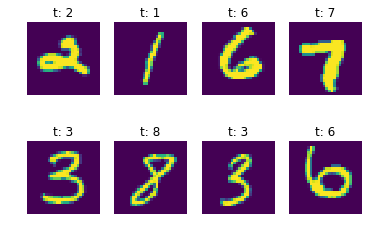

In [68]:
def plot_MNIST(images,labels):
    rows = 2
    columns = 4
    classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')
    # plot y_score - true label (t) vs predicted label (p)
    fig2 = plt.figure()
    for i in range(8):
        fig2.add_subplot(rows, columns, i+1)
        plt.title('t: ' + classes[labels[i].cpu()])
        img = images[i] / 2 + 0.5     # this is to unnormalize the image
        img = torchvision.transforms.ToPILImage()(img.cpu())
        plt.axis('off')
        plt.imshow(img)
    plt.show()


im_batch, lab_batch=next(iter(test_loader)) # view one batch
im_batch = im_batch.to(device)
plot_MNIST(im_batch,lab_batch)

The first thing we need to do is run inference on the images without occlusion

In [24]:
#running inference on the images without occlusion

# pretrained model
outputs = net(im_batch)

# #passing the outputs through softmax to interpret them as probability
# outputs = nn.functional.softmax(outputs, dim = 1)
# print(outputs)

#assigning the predicted label from the maximum softmax output
prob_no_occ, pred = torch.max(outputs.data, 1)

#get the first item
prob_no_occ = prob_no_occ[0].item()

print('Predictions = ', pred)

Predictions =  tensor([8, 0, 0, 3, 2, 6, 1, 7], device='cuda:0')


The first thing we need to be able to do is zero (or grey out) block of pixels in our image. 

Similar to the patch based selection that we saw in lecture 4, we are constrained to select only patches which fit in our image (which means that number of points on which we can start each patch is constrained by the width and height of our patch). This means that the output size will be smaller than the original image size by a factor of: (h-p)/s; where, h is the height (or width), p is the patch size and s is the chosen stride.

Let's create an image with an occluded patch in the centre. We start by first creating a copy of our image using `image.detach().clone()`.  Here, " `tensor.detach()` creates a tensor that shares storage with the original tensor, but for which `requires_grad=False`; `tensor.clone()` creates a copy of tensor that imitates the original tensor's `requires_grad` field. Thus `detach()` should be used to remove a tensor from a computation graph, and `clone()` copies the tensor while still keeping the copy as a part of the computation graph it came from. " quoted from https://discuss.pytorch.org/t/clone-and-detach-in-v0-4-0/16861.

#### To do 3.1 Create a function which occuldes a patch from an image

1. set all pixels of patch (starting at height: `heigh_start` and width: `width_start`, and of size: `patch_size` to 0.5
2. Pass the oculded image through the network (`model`) to make a prediction
3. Select the softmax output corresponding to the correct label for that image and print it out; 
  - note you will need to use `nn.functional.softmax()` on the output from your network in order to turn the log(softmax) output of the network back to a probability

In [57]:
def occlude_image(image, model, height_start,width_start,patch_size):
    ''' 
    Creates a copy of the image and occludes a patch 
    input:
    image (Pytorch tensor): image to be occluded
    model: Pytorch network model 
    height_start=starting index on height dimension
    width_start=starting index on width dimension
    patch_size: size of patch
    
    output: 
    probability
    '''
    occluded_image = im_batch[0].detach().clone()
    height_end=height_start+patch_size
    width_end=width_start+patch_size
    occluded_image[:,height_start:height_end,width_start:width_end]=0.5
    
    output_occluded=net(occluded_image.unsqueeze(0))
    occluded_prob=nn.functional.softmax(output_occluded, dim=1)[0,true_label]

    
    return occluded_prob, occluded_image

#### To do 3.2 Compare  against prediction probability when the full image is used

1. Get prediction probability when the full image is used and compare
2. Compare against probability for different patch locations and sizes; plot the occluded and original image to help you


2
True label=2; prediction probability for full image0.07124502956867218; prediction probability for occluded 0.0883224830031395


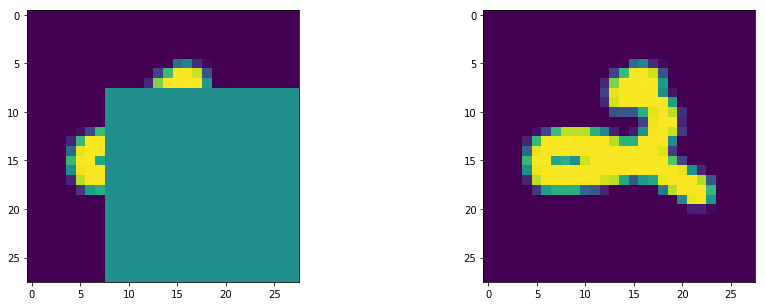

In [69]:
true_label=lab_batch[0].numpy()

print(true_label)
patch_size=20
height_start=8
width_start=8

#--------------- Task 3.2.1 Estimate output of network for first image of the batch -----------------#
# use nn.functional.softmax to return a probabiliyt
output_full=net(im_batch[0].unsqueeze(0))
full_prob=nn.functional.softmax(output_full,dim=1)[0,true_label]

#--------------- Task 3.2.2 Estimate output of network for an occluded version of the same image -----------------#
# use function defined above
occluded_prob, occluded_image=occlude_image(im_batch, net, height_start,width_start,patch_size)

print('True label={}; prediction probability for full image{}; prediction probability for occluded {}'
      .format(true_label,full_prob, occluded_prob))

# plot
fig2 = plt.figure(figsize=(15,5))
fig2.add_subplot(1, 2, 1)
#displaying the image using seaborn heatmap and also setting the maximum value of gradient to probability
img = torchvision.transforms.ToPILImage()(occluded_image[0].cpu())
plt.imshow(img)
fig2.add_subplot(1, 2, 2)
img = torchvision.transforms.ToPILImage()(im_batch[0].cpu())
plt.imshow(img)
plt.show()

Now we can iterate, creating patches across our entire image in order to create a heatmap which shows how big an impact a patch, centred on each pixel centre has.



In [70]:
#custom function to conduct occlusion experiments

def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
    print(image.shape,label)
    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride 
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            occluded_image = image.detach().clone()
#             print(type(image),image.shape)
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            occluded_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(occluded_image)
            
            # get the softmax output corresponding to the true label
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap



In [71]:
print(pred[0],pred[0].type)
image=im_batch[0].unsqueeze(0)
heatmap = occlusion(net, image, lab_batch[0].item(),13, 1)

tensor(8, device='cuda:0') <built-in method type of Tensor object at 0x7f4ac4791558>
torch.Size([1, 1, 28, 28]) 2


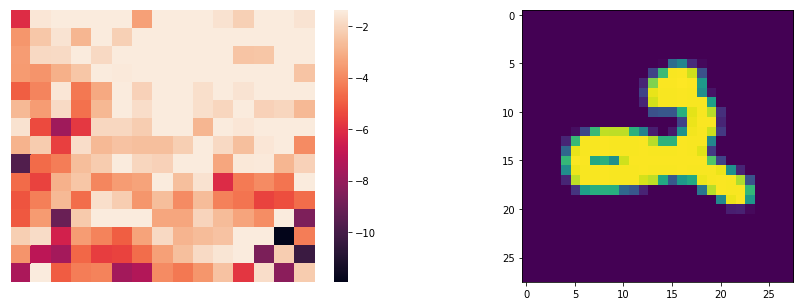

In [72]:
import seaborn as sns

fig2 = plt.figure(figsize=(15,5))
fig2.add_subplot(1, 2, 1)
#displaying the image using seaborn heatmap and also setting the maximum value of gradient to probability
imgplot = sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)
figure = imgplot.get_figure()    
fig2.add_subplot(1, 2, 2)
img = torchvision.transforms.ToPILImage()(image[0].cpu())
plt.imshow(img)
plt.show()

## Visualisation

The web journal [Distill.pub](https://distill.pub/) is a particularly strong source of information for those interested in network visualisation. In partiocular [this article](https://distill.pub/2017/feature-visualization/) by Chris Olah has been a strong source of information for this section.

### 3. CNN Layer Visualization

We will go through the next examples using code from the following repository https://github.com/utkuozbulak/pytorch-cnn-visualizations, which implements several well known visualization techniques for deep learning networks.

**CNN layer visualization** technique produces an image that minimizes the loss of a convolutional operation for a specific layer and filter - i.e. it learns the image that optimally activates a particular convolutional filter.

D. Erhan, Y. Bengio, A. Courville, P. Vincent. Visualizing Higher-Layer Features of a Deep Network https://www.researchgate.net/publication/265022827_Visualizing_Higher-Layer_Features_of_a_Deep_Network

**All the visualizations will be saved to** `/generated` folder

In [73]:
# load vgg model, and extract layers from the features modules only
pretrained_model = models.vgg16(pretrained=True).features


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/cb19/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [01:40<00:00, 5513680.82it/s] 


In [74]:
print(pretrained_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [75]:
cnn_layer = 21
filter_pos = 5
# Fully connected layer is not needed
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

# Layer visualization without pytorch hooks
#layer_vis.visualise_layer_without_hooks()


Iteration: 1 Loss: 0.96
Iteration: 2 Loss: 0.44
Iteration: 3 Loss: -3.77
Iteration: 4 Loss: -7.36
Iteration: 5 Loss: -10.98
Iteration: 6 Loss: -14.29
Iteration: 7 Loss: -17.33
Iteration: 8 Loss: -20.20
Iteration: 9 Loss: -22.94
Iteration: 10 Loss: -25.58
Iteration: 11 Loss: -28.12
Iteration: 12 Loss: -30.63
Iteration: 13 Loss: -33.11
Iteration: 14 Loss: -35.57
Iteration: 15 Loss: -38.01
Iteration: 16 Loss: -40.44
Iteration: 17 Loss: -42.85
Iteration: 18 Loss: -45.24
Iteration: 19 Loss: -47.64
Iteration: 20 Loss: -50.03
Iteration: 21 Loss: -52.40
Iteration: 22 Loss: -54.77
Iteration: 23 Loss: -57.14
Iteration: 24 Loss: -59.52
Iteration: 25 Loss: -61.91
Iteration: 26 Loss: -64.28
Iteration: 27 Loss: -66.65
Iteration: 28 Loss: -69.07
Iteration: 29 Loss: -71.48
Iteration: 30 Loss: -73.90


### Task 3: Visualize different CNN layers and filters
Change the CNN layer and filter to visualize the network at different depths

In [ ]:
# --------------------------------------------- Task 3 --------------------------------------------------------
# write code here



## 6. Deep Dream
Deep dream is a technique similar to layer visualization, that optimises an input image based on a selected convolutional filter. The main difference is that you start with a real picture, instead of a random noise image, and optmise that.

**All the visualizations will be saved to** `/generated` folder

See paper - https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [77]:
cnn_layer = 21
filter_pos = 5

im_path = './visualizations/input_images/dd_tree.jpg'
# Fully connected layer is not needed

dd = DeepDream(pretrained_model, cnn_layer, filter_pos, im_path)
# This operation can also be done without Pytorch hooks
# See layer visualisation for the implementation without hooks
dd.dream()


Iteration: 1 Loss: 5.40
Iteration: 2 Loss: 0.81
Iteration: 3 Loss: -4.40
Iteration: 4 Loss: -8.86
Iteration: 5 Loss: -12.73
Iteration: 6 Loss: -16.38
Iteration: 7 Loss: -19.44
Iteration: 8 Loss: -23.10
Iteration: 9 Loss: -26.64
Iteration: 10 Loss: -29.93
(117, 224, 3)
Iteration: 11 Loss: -32.64
Iteration: 12 Loss: -35.87
Iteration: 13 Loss: -39.08
Iteration: 14 Loss: -42.76
Iteration: 15 Loss: -45.75
Iteration: 16 Loss: -49.54
Iteration: 17 Loss: -53.64
Iteration: 18 Loss: -58.05
Iteration: 19 Loss: -60.94
Iteration: 20 Loss: -63.48
(117, 224, 3)
Iteration: 21 Loss: -67.32
Iteration: 22 Loss: -71.84
Iteration: 23 Loss: -75.33
Iteration: 24 Loss: -78.92
Iteration: 25 Loss: -82.60
Iteration: 26 Loss: -86.20
Iteration: 27 Loss: -89.10
Iteration: 28 Loss: -92.65
Iteration: 29 Loss: -95.70
Iteration: 30 Loss: -99.51
(117, 224, 3)
Iteration: 31 Loss: -102.96
Iteration: 32 Loss: -106.56
Iteration: 33 Loss: -109.42
Iteration: 34 Loss: -113.02
Iteration: 35 Loss: -116.61
Iteration: 36 Loss: -11

## 4. Gradient visualization with Guided backpropagation

In order to visualise what is learnt by neurons in higher layers, a deconvolutional approach was developed, which inverts the data flow of a CNN, going from a neuron of interest to an image. The resulting image is the one which most strongly activates this neuron.

![guided_backprop](guided_backprop.png)

Details of the backprop method is in the following reference:

Springenberg, Jost Tobias, et al. "Striving for simplicity: The all convolutional net." arXiv preprint arXiv:1412.6806 (2014)-
https://arxiv.org/pdf/1412.6806.pdf

You can find the implementation of guided backpropagation in `/visualizations/src/guided_backprop.py`.

First get input image, class label, and pretrained model (pretrained alexnet):

In [78]:
target_example = 0  
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)


Then you create an instance of the guidedbackprop class using `GuidedBackprop(pretrained_model)`. 
This operation creates hooks on the model, which updates relu activation functions so that:
1. it stores the output of the forward pass
2. it imputes zero for gradient values that are less than zero, i.e. all gradients are clamped to zero


In [79]:
print(pretrained_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [80]:
#--------------------------------------------------------- Guided backprop---------------------------------------------------
# Guided backprop
GBP = GuidedBackprop(pretrained_model)


 Then you can generate gradients that are specific to a particular input image, and class using the method `GP.generate_gradients()` with the following steps:
 1. go through a forward pass with the image input, and generate an output
 2. backprop through the output
 3. get the gradients from the backprop
 

In [81]:
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)

Then we can save the gradients using the following plotting functions

In [82]:
#--------------------------------------------------------- Save images-------------------------------------------------------
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Guided backprop completed')


Guided backprop completed


### Task 4: Run guided backprop for different inputs, and classes
You can do this by changing `target_example=` (there's 3 inputs available)


In [ ]:
# --------------------------------------------- Task 4 --------------------------------------------------------
# write code here


## 5. Gradient Class Activation Mapping (grad-CAM)


R. R. Selvaraju, A. Das, R. Vedantam, M. Cogswell, D. Parikh, and D. Batra. Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization, https://arxiv.org/abs/1610.02391

In [83]:
# Get params
target_example = 1
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)
# Save mask
save_class_activation_images(original_image, cam, file_name_to_export)
print('Grad cam completed')


Grad cam completed
